In [1]:
import state_space_system
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
import numpy as np
from casadi import *

from ERA import *
from kalman_filter import *
from utils_optimization_problem import *

mpl.rcParams['font.size'] = 20 # set the matplotlib parameter

## 1. System Identification ##

In [2]:
## system identification ##

q = 2   # Number of inputs
p = 3   # Number of outputs
r = 10  # Reduced model order

time = np.linspace(0, 20, num=500)
sys = state_space_system.sys()# import real system
sys.reset()
u = np.zeros((time.shape[0]-1, 2))
u[0,0] = 1
u1 = u

u = np.zeros((time.shape[0]-1, 2))
u[0,1] = 1
u2 = u

# average of 10 times measurement

re = 10 # repeated time for measurement

y_1 = np.zeros((time.shape[0],3))
y_2 = np.zeros((time.shape[0],3))
for n in range(re):
    y_1_t = sys.simulate(time, u1)
    # Concatenate:
    y_1_t = np.array(y_1_t)
    y_1 += y_1_t

    y_2_t = sys.simulate(time, u2)
    # Concatenate:
    y_2_t = np.array(y_2_t)
    y_2 += y_2_t
y_1 /= re
y_2 /= re
    
yFull = np.zeros((time.shape[0],p,q))

yFull[:,:,0] = y_1[:,:]
yFull[:,:,1] = y_2[:,:]

YY = np.transpose(yFull,axes=(1,2,0)) # reorder to size p x q x m 

# Compute reduced order model from impulse response
mco = int(np.floor((yFull.shape[0]-1)/2)) # m_c = m_o = (m-1)/2
Ar,Br,Cr,Dr,HSVs = ERA(YY,mco,mco,q,p,r)

# impulse response test for channel 1
y1 = []
x0 = np.zeros((Ar.shape[1],1)) 

for n in range(u1.shape[0]):
    temp = Cr@x0 + Dr@(u1[n]).reshape(Dr.shape[1],1)
    y1.append(temp)
    x0 = Ar@x0 + Br@(u1[n]).reshape(Dr.shape[1],1)
y1.append(Cr@x0)
# impulse response test for channel 2  
y2 = []
x0 = np.zeros((Ar.shape[1],1))

for n in range(u2.shape[0]):
    temp = Cr@x0 + Dr@(u2[n]).reshape(Dr.shape[1],1)
    y2.append(temp)
    x0 = Ar@x0 + Br@(u2[n]).reshape(Dr.shape[1],1)
y2.append(Cr@x0)

y1 = (np.array(y1)).reshape(time.shape[0],3)
y2 = (np.array(y2)).reshape(time.shape[0],3)

Text(0.5, 1.0, 'third mass')

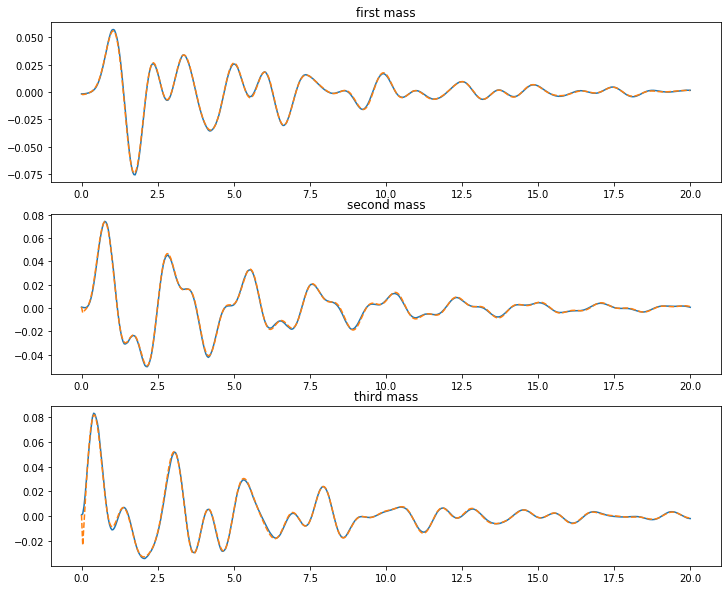

In [3]:
## ident sys. and original sys. ##
fig, (ax1, ax2, ax3) = plt.subplots(3,figsize=(12,10))
ax1.plot(time, y_2[:,0])
ax1.plot(time, y2[:,0], '--')
ax1.set_title('first mass')
ax2.plot(time, y_2[:,1])
ax2.plot(time, y2[:,1], '--')
ax2.set_title('second mass')
ax3.plot(time, y_2[:,2])
ax3.plot(time, y2[:,2], '--')
ax3.set_title('third mass')

Text(0.5, 1.0, 'third mass')

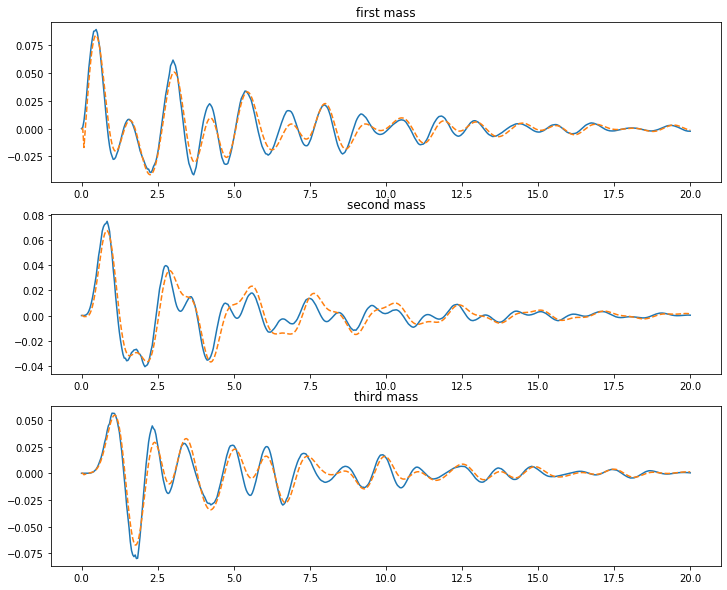

In [4]:
# Simulate the system with CasADi 
# allows to use any control input function
num_time =500

nx = Ar.shape[1] #set the number of state and the control inputs
nu = Br.shape[1]
ny = Cr.shape[0]

# different  control input functions u1, u2, u3
# create control input signal
u = np.zeros((time.shape[0]-1, 2))
u[0,0] = 1
u1 = u

u = np.zeros((time.shape[0]-1, 2))
u[0,1] = 1
u2 = u

u = np.zeros((time.shape[0]-1, 2))
u[:,0] = np.array(np.sin(np.linspace(-np.pi, np.pi, num_time-1))).T
u3 = 3*u


# Create a symbolic expression of the state-space system¶
x = SX.sym("x",nx,1)
u = SX.sym("u",nu,1)
x_next = Ar@x + Br@u 
y_k = Cr@x

# Create the CasADi function
system = Function("sys",[x,u],[x_next])
angles = Function("angle",[x,u],[y_k])

# Define the initial condition
x_0 = np.array([np.zeros(nx)]).reshape(nx,1)

# Define the input (for the moment consider u = 0)
u_k = u1
res_x = [x_0]
res_y = [np.array([np.zeros(ny)]).reshape(ny,1)]

for i in range(num_time-1):
    res_y.append(angles(x_0,u_k[i]))
    x_next = system(x_0,u_k[i])
    res_x.append(x_next)
    x_0 = x_next
    
# Make an array from the list of arrays:
res_x = np.concatenate(res_x,axis=1)
res_y = np.concatenate(res_y,axis=1)

# create control input signal
sys = state_space_system.sys()# import real system
sys.reset()

y_1 = sys.simulate(time, u1)
# Concatenate:
y_1 = np.array(y_1)

y_2 = sys.simulate(time, u1)
# Concatenate:
y_2 = np.array(y_2)

fig, (ax1, ax2, ax3) = plt.subplots(3,figsize=(12,10))

# plot the states
ax1.plot(time, y_1[:,0])
ax1.plot(time, res_y[0], '--')
ax1.set_title('first mass')
ax2.plot(time, y_1[:,1])
ax2.plot(time, res_y[1], '--')
ax2.set_title('second mass')
ax3.plot(time, y_1[:,2])
ax3.plot(time, res_y[2], '--')
ax3.set_title('third mass')

(-1, 1)

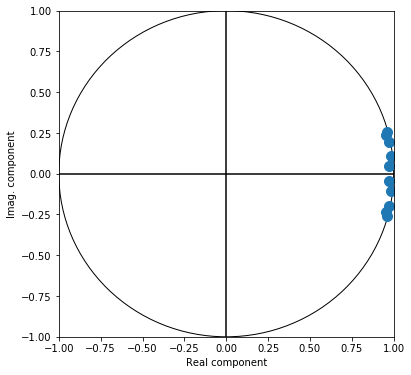

In [5]:
lam, v = np.linalg.eig(Ar)

fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlabel('Real component')
ax.set_ylabel('Imag. component')
ax.add_artist(plt.Circle((0, 0), 1,edgecolor='k', fill=False))
ax.plot(np.real(lam),np.imag(lam),'o', markersize=10)
ax.axhline(0,color='k')
ax.axvline(0,color='k')
ax.set_ylim(-1,1)
ax.set_xlim(-1,1)

# The stability region of a discrete-time system is within the unit circle. 
# As some of the eigenvalues lay directly on this circle, we can conclude that the system is stable,
# but not asymptotically stable.

In [20]:
## Augmented system ##
Ab,Bb,Cb = augmented_system(Ar,Br,Cr)
#set the number of state and the control inputs
nx = Ab.shape[1] 
nu = Bb.shape[1]
ny = Cb.shape[0]

(-1, 1)

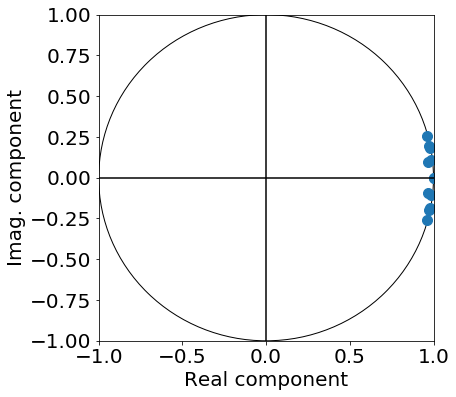

In [21]:
lam, v = np.linalg.eig(Ab)

fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlabel('Real component')
ax.set_ylabel('Imag. component')
ax.add_artist(plt.Circle((0, 0), 1,edgecolor='k', fill=False))
ax.plot(np.real(lam),np.imag(lam),'o', markersize=10)
ax.axhline(0,color='k')
ax.axvline(0,color='k')
ax.set_ylim(-1,1)
ax.set_xlim(-1,1)

# The stability region of a discrete-time system is within the unit circle. 
# As some of the eigenvalues lay directly on this circle, we can conclude that the system is stable,
# but not asymptotically stable.

# nothing has changed, that is good as we only augmented the system
# plot for Ar is enaugh for the report

## 2. simutaneous approach ##

In [22]:
## create a symbolic expression of state space ##
x = SX.sym("x",nx,1)
delta_u = SX.sym("delta_u",nu,1)

x_next = Ab@x + Bb@delta_u
system = Function("sys",[x,delta_u],[x_next]) # Create the CasADi function

In [23]:
## MPC initialization and casadi objective function ##
Q = 10                    # make it larger to get a more aggresive controller
Q = Q*np.diag(np.ones(ny)) # the state cost mutiplyer by using the output channel: ny=3

S = Q # S for terminal cost is equal to Q

R = 1                     # set it to 1, trying to reduce the influence from the control energy term
R = np.diag(R*np.ones(nu)) # the cost of control

N = 30                     # horizon

y_Ref = SX.sym("y_ref",ny,1)   # desired trajectory

# state cost
stage_cost = (y_Ref-Cb@x).T@Q@(y_Ref-Cb@x)+ delta_u.T@R@delta_u
stage_cost_fcn = Function('stage_cost',[x,delta_u,y_Ref],[stage_cost])

# terminal cost
terminal_cost = (y_Ref-Cb@x).T@S@(y_Ref-Cb@x)
terminal_cost_fcn = Function('terminal_cost',[x,y_Ref],[terminal_cost])

In [24]:
Q[2,2] = 0
S[2,2] = 0

In [25]:
# state constraints
lb_x = -10*np.ones((nx,1))
ub_x = 10*np.ones((nx,1))
# the last two state variables is actually the control inputs
lb_x[nx-nu:] = -5
ub_x[nx-nu:] = 5
# delta_u changing rate per step constraints
lb_u = -3*np.ones((nu,1))
ub_u = 3*np.ones((nu,1))

In [26]:
## create optimization problem ##
def casadi_setting(nx,nu): # reference_signal:3*15 output*horizon
    
    X = SX.sym("X",(N+1)*nx,1)
    delta_U = SX.sym("U",N*nu,1)
    reference_signal = SX.sym("r",N,ny)

    J = 0
    lb_X = [] # lower bound for X.
    ub_X = [] # upper bound for X
    lb_U = [] # lower bound for delta_U
    ub_U = [] # upper bound for delta_U
    g = []    # constraint expression g
    lb_g = []  # lower bound for constraint expression g
    ub_g = []  # upper bound for constraint expression g
    
    for k in range(N):
        # Retrieve parameters
        x_k = X[k*nx:(k+1)*nx,:]
        x_k_next = X[(k+1)*nx:(k+2)*nx,:]
        u_k = delta_U[k*nu:(k+1)*nu,:]
        
        # objective
        J += stage_cost_fcn(x_k,u_k,reference_signal[k,:])
        
        # equality constraints (system equation)
        x_k_next_calc = system(x_k,u_k)
        
        g.append(x_k_next - x_k_next_calc)
        lb_g.append(np.zeros((nx,1)))
        ub_g.append(np.zeros((nx,1)))


        # set the constraints of input and states
        lb_X.append(lb_x)
        ub_X.append(ub_x)
        lb_U.append(lb_u)
        ub_U.append(ub_u)
    
    # add the terminal cost 
    x_terminal = X[N*nx:(N+1)*nx,:]
    J += terminal_cost_fcn(x_terminal,reference_signal[-1,:])
    lb_X.append(lb_x)
    ub_X.append(ub_x)
    
    return lb_X,lb_U,ub_X,ub_U,X,delta_U,lb_g,ub_g,g,J,reference_signal

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

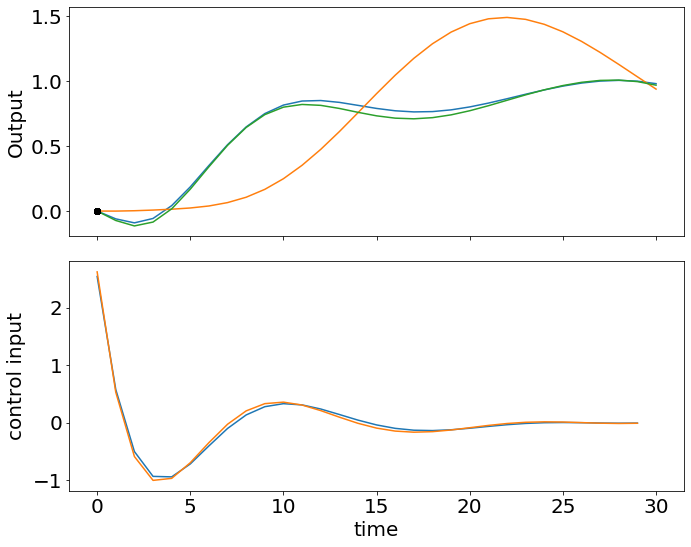

In [27]:
## test the functional solver production ##
reference = np.ones((N,ny))
lb_X,lb_U,ub_X,ub_U,X,delta_U,lb_g,ub_g,g,J,param = casadi_setting(nx,nu)
# Casadi solver
lbx = vertcat(*lb_X, *lb_U)
ubx = vertcat(*ub_X, *ub_U)
x = vertcat(X,delta_U)
g = vertcat(*g)
lbg = vertcat(*lb_g)
ubg = vertcat(*ub_g)

prob = {'f':J,'p':param,'x':x,'g':g}
solver = nlpsol('solver','ipopt',prob)

x_0 = np.zeros((nx,1))

lbx[:nx]=x_0
ubx[:nx]=x_0

res = solver(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,p=reference)

X = res['x'][:(N+1)*nx].full().reshape(N+1, nx)
delta_U = res['x'][(N+1)*nx:].full().reshape(N, nu)
Y = np.zeros((ny,1))

for n in range(N):
    temp = X[n+1].reshape(nx,1)
    Y = np.hstack((Y,Cb@temp))
    

# visulization of the result
fig, ax = plt.subplots(2,1, figsize=(10,8), sharex=True)
ax[0].plot(Y.T)
ax[1].plot(delta_U)
ax[0].set_ylabel('Output')
ax[1].set_ylabel('control input')
ax[1].set_xlabel('time')

# Highlight the selected initial state (the lines should start here!)
ax[0].plot(0,x_0.T, 'o', color='black')

fig.align_ylabels()
fig.tight_layout()

## test result looks resonable

In [28]:
N_sim = 500 # total simulation step
time = np.linspace(0, 20, num=N_sim)
#################################### compensate for the last time step for 13 units shape:(3, 513)
REFERENCE = np.ones((ny,N_sim+N-1))

# constant tracking
REFERENCE[:,150:] = 2
REFERENCE[:,400:] = 1

# trigonometric tracking
#REFERENCE[0,:] = np.array(np.sin(np.linspace(-3*np.pi, 3*np.pi, N_sim+N-1))).T
#REFERENCE[1,:] = np.array(np.sin(np.linspace(-3*np.pi+2*np.pi/3, 3*np.pi+2*np.pi/3, N_sim+N-1))).T
#REFERENCE[2,:] = np.array(np.sin(np.linspace(-3*np.pi+2*2*np.pi/3, 3*np.pi+2*2*np.pi/3, N_sim+N-1))).T
#################################### reference change test

In [29]:
%%time
## MPC main loop ##
x_0 = np.zeros((nx,1))
res_x = [x_0]
res_delta_u = []
res_u = []

## original system measurement initialization
sys.reset()
y_res = [sys.make_measurement()]

## kalman filter parameters
P_k = np.eye(Ab.shape[0],Ab.shape[1])
Q_k = np.ones((Ab.shape[0],Ab.shape[1]))
R_k = np.eye(Cb.shape[0],Cb.shape[0])

X = []

for i in range(N_sim-1):
    
    reference = REFERENCE[:,i:i+N].T
    
    lb_X,lb_U,ub_X,ub_U,X,delta_U,lb_g,ub_g,g,J,param = casadi_setting(nx,nu)
    
    # Casadi solver
    lbx = vertcat(*lb_X, *lb_U)
    ubx = vertcat(*ub_X, *ub_U)
    x = vertcat(X,delta_U)
    g = vertcat(*g)
    lbg = vertcat(*lb_g)
    ubg = vertcat(*ub_g)
    
    # only create solver at the time step 1
    if i == 0:
        prob = {'f':J,'p':param,'x':x,'g':g}
        solver = nlpsol('solver','ipopt',prob)
    # set the starting state
    lbx[:nx]=x_0
    ubx[:nx]=x_0
    
    # solving the optimization problem
    res = solver(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,p=reference)
    delta_u_k = res['x'][(N+1)*nx:(N+1)*nx+nu,:].full()
    
    X = res['x'][:(N+1)*nx].full().reshape(N+1, nx)
    u_st = X[0,10:].reshape(nu,1)+ delta_u_k
    res_u.append(u_st)
    # simulate the system
    sys.simulate(time[i:i+2], (np.array(u_st)).reshape(1,2))
    
    # Append new measurement
    y_res.append(sys.make_measurement())
    
    # state Estimation using kalman filter
    xpred, Ppred = predict(x_0, (np.array(delta_u_k)).reshape(Bb.shape[1],1), P_k, Ab, Q_k, Bb)
    K = K_G(P_k,Cb,R_k)
    x_next,P_k = update(xpred,K,y_res[i+1],Cb,P_k,R_k,Ab)
    
    res_x.append(x_next)
    x_0 = x_next # update the current state

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9.2723124e+002 4.46e+000 8.10e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 1.5222607e+002 2.66e-015 3.30e-001  -1.0 4.95e+000    -  6.67e-001 1.00e+000f  1
   2 1.4457039e+002 3.55e-015 1.28e-001  -1.0 5.12e-001    -  8.39e-001 1.00e+000f  1
   3 1.4441150e+002 2.66e-015 7.22e-003  -1.7 5.47e-001    -  9.57e-001 1.00e+000f  

   1 7.1334055e+001 1.78e-015 3.45e-001  -1.0 5.09e+000    -  6.61e-001 1.00e+000f  1
   2 6.4966567e+001 2.66e-015 2.74e-002  -1.0 8.83e-001    -  9.55e-001 1.00e+000f  1
   3 6.4561982e+001 1.78e-015 7.76e-003  -1.7 1.40e+000    -  9.16e-001 1.00e+000f  1
   4 6.4527868e+001 2.66e-015 7.49e-015  -2.5 5.17e-001    -  1.00e+000 1.00e+000f  1
   5 6.4527455e+001 3.55e-015 4.95e-015  -3.8 6.20e-002    -  1.00e+000 1.00e+000f  1
   6 6.4527455e+001 4.44e-015 3.34e-015  -5.7 1.39e-003    -  1.00e+000 1.00e+000h  1
   7 6.4527455e+001 4.44e-015 4.85e-015  -8.6 9.37e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  6.4527455019676381e+001   6.4527455019676381e+001
Dual infeasibility......:  4.8485672031295488e-015   4.8485672031295488e-015
Constraint violation....:  4.4408920985006262e-015   4.4408920985006262e-015
Complementarity.........:  2.5093010441726085e-009   2.50930104417

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

   2 2.5500687e+001 1.78e-015 3.09e-002  -1.0 9.75e-001    -  9.54e-001 1.00e+000f  1
   3 2.5080789e+001 3.55e-015 8.78e-003  -1.7 1.37e+000    -  9.13e-001 1.00e+000f  1
   4 2.5042979e+001 3.11e-015 5.40e-015  -2.5 5.43e-001    -  1.00e+000 1.00e+000f  1
   5 2.5042472e+001 3.55e-015 3.62e-015  -3.8 6.91e-002    -  1.00e+000 1.00e+000f  1
   6 2.5042472e+001 1.78e-015 3.40e-015  -5.7 1.52e-003    -  1.00e+000 1.00e+000h  1
   7 2.5042472e+001 1.78e-015 3.36e-015  -8.6 8.86e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  2.5042472245533446e+001   2.5042472245533446e+001
Dual infeasibility......:  3.3644711147757346e-015   3.3644711147757346e-015
Constraint violation....:  1.7763568394002505e-015   1.7763568394002505e-015
Complementarity.........:  2.5097341618065493e-009   2.5097341618065493e-009
Overall NLP error.......:  2.5097341618065493e-009   2.5097341618065493e-00

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9.0227137e+002 5.53e+000 8.10e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 2.7009094e+001 2.66e-015 3.85e-001  -1.0 5.43e+000    -  6.46e-001 1.00e+000f  1
   2 2.0003106e+001 2.66e-015 2.73e-002  -1.0 8.75e-001    -  9.60e-001 1.00e+000f  1
   3 1.9702223e+001 2.66e-015 7.12e-003  -1.7 1.15e+000    -  9.29e-001 1.00e+000f  

   7 1.3035626e+001 2.66e-015 2.89e-015  -8.6 5.49e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.3035626150764996e+001   1.3035626150764996e+001
Dual infeasibility......:  2.8881099496352831e-015   2.8881099496352831e-015
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5077132315801209e-009   2.5077132315801209e-009
Overall NLP error.......:  2.5077132315801209e-009   2.5077132315801209e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9.0026470e+002 3.75e+000 8.10e+000  -1.0 0.00e+000    -  0.00e+00

   4 3.0563464e+000 2.66e-015 2.87e-015  -2.5 3.19e-001    -  1.00e+000 1.00e+000f  1
   5 3.0562629e+000 3.55e-015 3.16e-015  -3.8 2.78e-002    -  1.00e+000 1.00e+000f  1
   6 3.0562629e+000 2.66e-015 2.72e-015  -5.7 6.66e-004    -  1.00e+000 1.00e+000h  1
   7 3.0562629e+000 1.78e-015 3.13e-015  -8.6 6.26e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  3.0562628595115644e+000   3.0562628595115644e+000
Dual infeasibility......:  3.1341654239859117e-015   3.1341654239859117e-015
Constraint violation....:  1.7763568394002505e-015   1.7763568394002505e-015
Complementarity.........:  2.5079262949575054e-009   2.5079262949575054e-009
Overall NLP error.......:  2.5079262949575054e-009   2.5079262949575054e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            =

   3 2.5827151e+000 2.66e-015 4.21e-003  -1.7 1.12e+000    -  9.43e-001 1.00e+000f  1
   4 2.5676976e+000 2.66e-015 2.90e-015  -2.5 3.52e-001    -  1.00e+000 1.00e+000f  1
   5 2.5675837e+000 2.66e-015 3.34e-015  -3.8 3.25e-002    -  1.00e+000 1.00e+000f  1
   6 2.5675837e+000 1.78e-015 2.71e-015  -5.7 7.53e-004    -  1.00e+000 1.00e+000h  1
   7 2.5675837e+000 3.55e-015 2.52e-015  -8.6 6.75e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  2.5675836876952589e+000   2.5675836876952589e+000
Dual infeasibility......:  2.5179582192812688e-015   2.5179582192812688e-015
Constraint violation....:  3.5527136788005009e-015   3.5527136788005009e-015
Complementarity.........:  2.5081719969251731e-009   2.5081719969251731e-009
Overall NLP error.......:  2.5081719969251731e-009   2.5081719969251731e-009


Number of objective function evaluations             = 8
Number of objective gradi

   4 2.2004689e+000 3.55e-015 2.90e-015  -2.5 3.77e-001    -  1.00e+000 1.00e+000f  1
   5 2.2003274e+000 2.66e-015 3.11e-015  -3.8 3.63e-002    -  1.00e+000 1.00e+000f  1
   6 2.2003274e+000 4.44e-015 3.26e-015  -5.7 8.17e-004    -  1.00e+000 1.00e+000h  1
   7 2.2003274e+000 1.78e-015 2.62e-015  -8.6 7.02e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  2.2003273591359482e+000   2.2003273591359482e+000
Dual infeasibility......:  2.6202609792962914e-015   2.6202609792962914e-015
Constraint violation....:  1.7763568394002505e-015   1.7763568394002505e-015
Complementarity.........:  2.5083303621714936e-009   2.5083303621714936e-009
Overall NLP error.......:  2.5083303621714936e-009   2.5083303621714936e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            =

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

   4 1.7878692e+000 3.55e-015 1.89e-015  -2.5 3.77e-001    -  1.00e+000 1.00e+000f  1
   5 1.7877315e+000 3.55e-015 2.54e-015  -3.8 3.59e-002    -  1.00e+000 1.00e+000f  1
   6 1.7877314e+000 2.66e-015 3.68e-015  -5.7 7.87e-004    -  1.00e+000 1.00e+000h  1
   7 1.7877314e+000 2.66e-015 2.57e-015  -8.6 6.71e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.7877313943456010e+000   1.7877313943456010e+000
Dual infeasibility......:  2.5745903392088788e-015   2.5745903392088788e-015
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5082204905962138e-009   2.5082204905962138e-009
Overall NLP error.......:  2.5082204905962138e-009   2.5082204905962138e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            =

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9.0018107e+002 4.49e+000 8.10e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 8.6627631e+000 1.78e-015 2.74e-001  -1.0 4.43e+000    -  6.91e-001 1.00e+000f  1
   2 1.6588070e+000 1.78e-015 1.73e-002  -1.0 8.38e-001    -  9.71e-001 1.00e+000f  1
   3 1.4156817e+000 2.66e-015 4.75e-003  -1.7 1.08e+000    -  9.42e-001 1.00e+000f  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9.0001299e+002 4.37e+000 8.10e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 8.1828710e+000 1.78e-015 2.60e-001  -1.0 4.30e+000    -  6.97e-001 1.00e+000f  1
   2 1.1215323e+000 1.33e-015 1.58e-002  -1.0 8.37e-001    -  9.73e-001 1.00e+000f  1
   3 8.7485633e-001 1.78e-015 4.47e-003  -1.7 1.10e+000    -  9.43e-001 1.00e+000f  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

   1 7.9731045e+000 1.33e-015 2.57e-001  -1.0 4.27e+000    -  6.99e-001 1.00e+000f  1
   2 9.6187095e-001 1.78e-015 1.57e-002  -1.0 8.36e-001    -  9.73e-001 1.00e+000f  1
   3 7.2192011e-001 2.66e-015 4.39e-003  -1.7 1.08e+000    -  9.44e-001 1.00e+000f  1
   4 7.0770581e-001 3.55e-015 2.60e-015  -2.5 3.43e-001    -  1.00e+000 1.00e+000f  1
   5 7.0760279e-001 1.78e-015 2.07e-015  -3.8 3.10e-002    -  1.00e+000 1.00e+000f  1
   6 7.0760274e-001 2.66e-015 2.66e-015  -5.7 7.08e-004    -  1.00e+000 1.00e+000h  1
   7 7.0760274e-001 2.66e-015 2.52e-015  -8.6 6.39e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  7.0760274006015811e-001   7.0760274006015811e-001
Dual infeasibility......:  2.5160619507403828e-015   2.5160619507403828e-015
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5080402071635653e-009   2.50804020716

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9.0001794e+002 4.33e+000 8.10e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 8.0093915e+000 1.33e-015 2.57e-001  -1.0 4.26e+000    -  6.99e-001 1.00e+000f  1
   2 9.3730235e-001 1.78e-015 1.54e-002  -1.0 8.42e-001    -  9.73e-001 1.00e+000f  1
   3 6.9352150e-001 1.78e-015 4.45e-003  -1.7 1.09e+000    -  9.43e-001 1.00e+000f  

Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/o function evaluations)   =      0.031
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         8
       nlp_g  |        0 (       0)        0 (       0)         8
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         9
  nlp_hess_l  |        0 (       0)        0 (       0)         7
   nlp_jac_g  |        0 (       0)        0 (       0)         9
       total  |  47.00ms ( 47.00ms)  46.87ms ( 46.87ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentatio


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/o function evaluations)   =      0.031
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         8
       nlp_g  |        0 (       0)        0 (       0)         8
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         9
  nlp_hess_l  |        0 (       0)        0 (       0)         7
   nlp_jac_g  |        0 (       0)      

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

   3 7.5595195e-001 1.78e-015 4.34e-003  -1.7 1.08e+000    -  9.44e-001 1.00e+000f  1
   4 7.4178520e-001 2.66e-015 2.90e-015  -2.5 3.43e-001    -  1.00e+000 1.00e+000f  1
   5 7.4168257e-001 2.66e-015 3.09e-015  -3.8 3.09e-002    -  1.00e+000 1.00e+000f  1
   6 7.4168251e-001 3.55e-015 3.17e-015  -5.7 7.09e-004    -  1.00e+000 1.00e+000h  1
   7 7.4168251e-001 1.78e-015 2.83e-015  -8.6 6.41e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  7.4168251257864348e-001   7.4168251257864348e-001
Dual infeasibility......:  2.8349770816314581e-015   2.8349770816314581e-015
Constraint violation....:  1.7763568394002505e-015   1.7763568394002505e-015
Complementarity.........:  2.5080412961115674e-009   2.5080412961115674e-009
Overall NLP error.......:  2.5080412961115674e-009   2.5080412961115674e-009


Number of objective function evaluations             = 8
Number of objective gradi

   5 7.4944143e-001 3.55e-015 3.30e-015  -3.8 3.12e-002    -  1.00e+000 1.00e+000f  1
   6 7.4944137e-001 3.55e-015 2.93e-015  -5.7 7.14e-004    -  1.00e+000 1.00e+000h  1
   7 7.4944137e-001 2.66e-015 3.25e-015  -8.6 6.43e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  7.4944137086528451e-001   7.4944137086528451e-001
Dual infeasibility......:  3.2464995951952670e-015   3.2464995951952670e-015
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5080524118319507e-009   2.5080524118319507e-009
Overall NLP error.......:  2.5080524118319507e-009   2.5080524118319507e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constra

   4 7.4106963e-001 4.44e-015 2.83e-015  -2.5 3.47e-001    -  1.00e+000 1.00e+000f  1
   5 7.4096345e-001 1.78e-015 2.90e-015  -3.8 3.14e-002    -  1.00e+000 1.00e+000f  1
   6 7.4096339e-001 2.66e-015 4.52e-015  -5.7 7.17e-004    -  1.00e+000 1.00e+000h  1
   7 7.4096339e-001 2.66e-015 2.62e-015  -8.6 6.44e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  7.4096339113547338e-001   7.4096339113547338e-001
Dual infeasibility......:  2.6244076026197953e-015   2.6244076026197953e-015
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5080592447400427e-009   2.5080592447400427e-009
Overall NLP error.......:  2.5080592447400427e-009   2.5080592447400427e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            =

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9.0003821e+002 4.36e+000 8.10e+000  -1.0 0.00e+000    -  0.00e+00

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9.0003585e+002 4.35e+000 8.10e+000  -1.0 0.00e+000    -  0.00e+00

   8 2.5578075e+001 7.11e-015 3.46e-015  -8.6 2.62e-006    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:  2.5578075397557143e+001   2.5578075397557143e+001
Dual infeasibility......:  3.4645190730851663e-015   3.4645190730851663e-015
Constraint violation....:  7.1054273576010019e-015   7.1054273576010019e-015
Complementarity.........:  2.5267816003593636e-009   2.5267816003593636e-009
Overall NLP error.......:  2.5267816003593636e-009   2.5267816003593636e-009


Number of objective function evaluations             = 9
Number of objective gradient evaluations             = 9
Number of equality constraint evaluations            = 9
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 9
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 8
Total CPU secs in IPOPT (w/

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1.3500246e+003 4.04e+000 1.09e+001  -1.0 0.00e+000    -  0.00e+00

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1.8001003e+003 4.15e+000 1.37e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 6.1889231e+001 3.55e-015 7.72e-001  -1.0 8.40e+000    -  5.41e-001 1.00e+000f  1
   2 3.6205772e+001 4.44e-015 2.07e-002  -1.0 1.31e+000    -  9.61e-001 1.00e+000f  1
   3 3.4226158e+001 8.88e-015 1.86e-002  -1.7 6.93e-001    -  9.51e-001 1.00e+000f  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2.3400181e+003 5.03e+000 1.52e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 7.6563577e+001 3.55e-015 7.61e-001  -1.0 8.33e+000    -  5.43e-001 1.00e+000f  1
   2 5.0165832e+001 3.55e-015 3.04e-002  -1.0 1.17e+000    -  9.48e-001 1.00e+000f  1
   3 4.8269855e+001 7.11e-015 5.68e-002  -1.7 1.02e+000    -  8.61e-001 1.00e+000f  1
   4 4.7906494e+001 5.33e-015 5.86e-015  -1.7 1.05e+000    -  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

   3 5.1235885e+001 5.33e-015 6.05e-002  -1.7 9.88e-001    -  8.44e-001 1.00e+000f  1
   4 5.1060641e+001 5.33e-015 6.65e-015  -1.7 8.79e-001    -  1.00e+000 1.00e+000f  1
   5 5.1045655e+001 5.33e-015 7.40e-015  -2.5 2.85e-001    -  1.00e+000 1.00e+000f  1
   6 5.1045355e+001 5.33e-015 5.00e-015  -3.8 4.60e-002    -  1.00e+000 1.00e+000f  1
   7 5.1045354e+001 5.33e-015 6.25e-015  -5.7 1.67e-003    -  1.00e+000 1.00e+000f  1
   8 5.1045354e+001 5.33e-015 7.60e-015  -8.6 1.31e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:  5.1045354248316755e+001   5.1045354248316755e+001
Dual infeasibility......:  7.5964844120274174e-015   7.5964844120274174e-015
Constraint violation....:  5.3290705182007514e-015   5.3290705182007514e-015
Complementarity.........:  2.5150235136685046e-009   2.5150235136685046e-009
Overall NLP error.......:  2.5150235136685046e-009   2.5150235136685046e-00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

   4 4.3463454e+001 7.11e-015 4.66e-015  -1.7 1.34e+000    -  1.00e+000 1.00e+000f  1
   5 4.3383621e+001 7.11e-015 4.91e-015  -2.5 6.79e-001    -  1.00e+000 1.00e+000f  1
   6 4.3379276e+001 5.33e-015 6.58e-015  -3.8 1.87e-001    -  1.00e+000 1.00e+000f  1
   7 4.3379239e+001 5.33e-015 7.89e-015  -3.8 1.67e-002    -  1.00e+000 1.00e+000f  1
   8 4.3379239e+001 5.33e-015 5.58e-015  -5.7 2.29e-003    -  1.00e+000 1.00e+000f  1
   9 4.3379239e+001 5.33e-015 6.50e-015  -8.6 2.94e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:  4.3379238807384773e+001   4.3379238807384773e+001
Dual infeasibility......:  6.5008442771991053e-015   6.5008442771991053e-015
Constraint violation....:  5.3290705182007514e-015   5.3290705182007514e-015
Complementarity.........:  2.5530431974396463e-009   2.5530431974396463e-009
Overall NLP error.......:  2.5530431974396463e-009   2.5530431974396463e-00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

   3 4.6918109e+000 5.33e-015 7.00e-002  -1.7 1.24e+000    -  8.09e-001 1.00e+000f  1
   4 4.3783675e+000 7.11e-015 5.35e-015  -1.7 1.15e+000    -  1.00e+000 1.00e+000f  1
   5 4.3289844e+000 5.33e-015 5.66e-015  -2.5 5.37e-001    -  1.00e+000 1.00e+000f  1
   6 4.3263748e+000 5.33e-015 7.88e-015  -3.8 1.47e-001    -  1.00e+000 1.00e+000f  1
   7 4.3263600e+000 5.33e-015 5.00e-015  -5.7 1.19e-002    -  1.00e+000 1.00e+000f  1
   8 4.3263600e+000 5.33e-015 5.52e-015  -8.6 9.69e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:  4.3263600419601129e+000   4.3263600419601129e+000
Dual infeasibility......:  5.5204128257657745e-015   5.5204128257657745e-015
Constraint violation....:  5.3290705182007514e-015   5.3290705182007514e-015
Complementarity.........:  3.3318438003849536e-009   3.3318438003849536e-009
Overall NLP error.......:  3.3318438003849536e-009   3.3318438003849536e-00

   7 3.9285347e+000 5.33e-015 5.41e-015  -3.8 1.34e-002    -  1.00e+000 1.00e+000f  1
   8 3.9285341e+000 7.11e-015 6.90e-015  -5.7 2.23e-003    -  1.00e+000 1.00e+000f  1
   9 3.9285341e+000 5.33e-015 7.16e-015  -8.6 2.92e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:  3.9285341353557044e+000   3.9285341353557044e+000
Dual infeasibility......:  7.1594145245065818e-015   7.1594145245065818e-015
Constraint violation....:  5.3290705182007514e-015   5.3290705182007514e-015
Complementarity.........:  2.5507377150481147e-009   2.5507377150481147e-009
Overall NLP error.......:  2.5507377150481147e-009   2.5507377150481147e-009


Number of objective function evaluations             = 10
Number of objective gradient evaluations             = 10
Number of equality constraint evaluations            = 10
Number of inequality constraint evaluations          = 0
Number of equality cons

   2 6.1486938e+000 3.55e-015 6.80e-002  -1.0 1.26e+000    -  9.14e-001 1.00e+000f  1
   3 4.3933334e+000 5.33e-015 7.13e-002  -1.7 1.32e+000    -  8.00e-001 1.00e+000f  1
   4 4.0277567e+000 8.88e-015 5.53e-015  -1.7 1.22e+000    -  1.00e+000 1.00e+000f  1
   5 3.9624256e+000 5.33e-015 6.03e-015  -2.5 6.01e-001    -  1.00e+000 1.00e+000f  1
   6 3.9578961e+000 7.11e-015 5.41e-015  -3.8 1.88e-001    -  1.00e+000 1.00e+000f  1
   7 3.9578461e+000 5.33e-015 6.83e-015  -3.8 1.96e-002    -  1.00e+000 1.00e+000f  1
   8 3.9578453e+000 7.11e-015 5.62e-015  -5.7 2.61e-003    -  1.00e+000 1.00e+000f  1
   9 3.9578453e+000 7.11e-015 5.99e-015  -8.6 3.35e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:  3.9578453293811644e+000   3.9578453293811644e+000
Dual infeasibility......:  5.9905563852615752e-015   5.9905563852615752e-015
Constraint violation....:  7.1054273576010019e-015   7.10

   3 4.6278417e+000 7.11e-015 7.16e-002  -1.7 1.34e+000    -  8.00e-001 1.00e+000f  1
   4 4.2306814e+000 7.11e-015 4.95e-015  -1.7 1.24e+000    -  1.00e+000 1.00e+000f  1
   5 4.1539300e+000 5.33e-015 7.07e-015  -2.5 6.35e-001    -  1.00e+000 1.00e+000f  1
   6 4.1475034e+000 5.33e-015 5.97e-015  -3.8 2.18e-001    -  1.00e+000 1.00e+000f  1
   7 4.1473890e+000 5.33e-015 5.56e-015  -3.8 3.02e-002    -  1.00e+000 1.00e+000f  1
   8 4.1473877e+000 5.33e-015 6.19e-015  -5.7 3.40e-003    -  1.00e+000 1.00e+000f  1
   9 4.1473877e+000 1.07e-014 6.28e-015  -8.6 4.20e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:  4.1473876964979040e+000   4.1473876964979040e+000
Dual infeasibility......:  6.2810646648448116e-015   6.2810646648448116e-015
Constraint violation....:  1.0658141036401503e-014   1.0658141036401503e-014
Complementarity.........:  2.6165241914403132e-009   2.61652419144

   6 4.0306404e+000 5.33e-015 5.84e-015  -3.8 2.21e-001    -  1.00e+000 1.00e+000f  1
   7 4.0305164e+000 5.33e-015 5.71e-015  -3.8 3.14e-002    -  1.00e+000 1.00e+000f  1
   8 4.0305150e+000 5.33e-015 7.13e-015  -5.7 3.52e-003    -  1.00e+000 1.00e+000f  1
   9 4.0305150e+000 3.55e-015 6.79e-015  -8.6 4.33e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:  4.0305149853958113e+000   4.0305149853958113e+000
Dual infeasibility......:  6.7910181905264132e-015   6.7910181905264132e-015
Constraint violation....:  3.5527136788005009e-015   3.5527136788005009e-015
Complementarity.........:  2.6237120598905933e-009   2.6237120598905933e-009
Overall NLP error.......:  2.6237120598905933e-009   2.6237120598905933e-009


Number of objective function evaluations             = 10
Number of objective gradient evaluations             = 10
Number of equality constraint evaluations           

   7 3.7251852e+000 4.44e-015 7.41e-015  -3.8 2.86e-002    -  1.00e+000 1.00e+000f  1
   8 3.7251839e+000 8.88e-015 5.88e-015  -5.7 3.27e-003    -  1.00e+000 1.00e+000f  1
   9 3.7251839e+000 5.33e-015 5.54e-015  -8.6 4.08e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:  3.7251839373592128e+000   3.7251839373592128e+000
Dual infeasibility......:  5.5409304386726664e-015   5.5409304386726664e-015
Constraint violation....:  5.3290705182007514e-015   5.3290705182007514e-015
Complementarity.........:  2.6054303067960231e-009   2.6054303067960231e-009
Overall NLP error.......:  2.6054303067960231e-009   2.6054303067960231e-009


Number of objective function evaluations             = 10
Number of objective gradient evaluations             = 10
Number of equality constraint evaluations            = 10
Number of inequality constraint evaluations          = 0
Number of equality cons

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3.6001421e+003 8.63e+000 1.62e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 3.1869326e+001 4.44e-015 7.86e-001  -1.0 8.50e+000    -  5.38e-001 1.00e+000f  1
   2 4.8068108e+000 3.55e-015 6.32e-002  -1.0 1.24e+000    -  9.20e-001 1.00e+000f  1
   3 3.0861756e+000 4.44e-015 7.05e-002  -1.7 1.28e+000    -  8.06e-001 1.00e+000f  

   5 2.6124480e+000 5.33e-015 6.04e-015  -2.5 5.94e-001    -  1.00e+000 1.00e+000f  1
   6 2.6079313e+000 5.33e-015 5.78e-015  -3.8 1.88e-001    -  1.00e+000 1.00e+000f  1
   7 2.6078815e+000 5.33e-015 6.48e-015  -3.8 1.96e-002    -  1.00e+000 1.00e+000f  1
   8 2.6078807e+000 5.33e-015 5.90e-015  -5.7 2.61e-003    -  1.00e+000 1.00e+000f  1
   9 2.6078807e+000 5.33e-015 6.38e-015  -8.6 3.37e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:  2.6078806982477536e+000   2.6078806982477536e+000
Dual infeasibility......:  6.3835868063931732e-015   6.3835868063931732e-015
Constraint violation....:  5.3290705182007514e-015   5.3290705182007514e-015
Complementarity.........:  2.5681417973057714e-009   2.5681417973057714e-009
Overall NLP error.......:  2.5681417973057714e-009   2.5681417973057714e-009


Number of objective function evaluations             = 10
Number of objective grad

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3.6000481e+003 8.61e+000 1.62e+001  -1.0 0.00e+000    -  0.00e+00

   8 2.8115976e+000 3.55e-015 5.25e-015  -5.7 2.69e-003    -  1.00e+000 1.00e+000f  1
   9 2.8115976e+000 5.33e-015 5.76e-015  -8.6 3.45e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:  2.8115975899407584e+000   2.8115975899407584e+000
Dual infeasibility......:  5.7622387602082969e-015   5.7622387602082969e-015
Constraint violation....:  5.3290705182007514e-015   5.3290705182007514e-015
Complementarity.........:  2.5723016855870975e-009   2.5723016855870975e-009
Overall NLP error.......:  2.5723016855870975e-009   2.5723016855870975e-009


Number of objective function evaluations             = 10
Number of objective gradient evaluations             = 10
Number of equality constraint evaluations            = 10
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 10
Number of inequality constraint Jacobian evaluation

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

   3 3.4699064e+000 3.55e-015 7.08e-002  -1.7 1.30e+000    -  8.04e-001 1.00e+000f  1
   4 3.0994736e+000 5.33e-015 5.98e-015  -1.7 1.22e+000    -  1.00e+000 1.00e+000f  1
   5 3.0317983e+000 5.33e-015 4.95e-015  -2.5 6.07e-001    -  1.00e+000 1.00e+000f  1
   6 3.0268454e+000 5.33e-015 4.96e-015  -3.8 1.96e-001    -  1.00e+000 1.00e+000f  1
   7 3.0267842e+000 5.33e-015 5.87e-015  -3.8 2.18e-002    -  1.00e+000 1.00e+000f  1
   8 3.0267833e+000 3.55e-015 8.27e-015  -5.7 2.75e-003    -  1.00e+000 1.00e+000f  1
   9 3.0267833e+000 5.33e-015 5.63e-015  -8.6 3.52e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:  3.0267833056241549e+000   3.0267833056241549e+000
Dual infeasibility......:  5.6348121956494338e-015   5.6348121956494338e-015
Constraint violation....:  5.3290705182007514e-015   5.3290705182007514e-015
Complementarity.........:  2.5752722796937337e-009   2.57527227969

   5 2.9534974e+000 5.33e-015 7.11e-015  -2.5 6.08e-001    -  1.00e+000 1.00e+000f  1
   6 2.9484676e+000 7.11e-015 4.81e-015  -3.8 1.97e-001    -  1.00e+000 1.00e+000f  1
   7 2.9484040e+000 7.11e-015 6.39e-015  -3.8 2.23e-002    -  1.00e+000 1.00e+000f  1
   8 2.9484031e+000 5.33e-015 5.86e-015  -5.7 2.79e-003    -  1.00e+000 1.00e+000f  1
   9 2.9484031e+000 5.33e-015 8.04e-015  -8.6 3.55e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:  2.9484031132717763e+000   2.9484031132717763e+000
Dual infeasibility......:  8.0390527477509053e-015   8.0390527477509053e-015
Constraint violation....:  5.3290705182007514e-015   5.3290705182007514e-015
Complementarity.........:  2.5770226686018571e-009   2.5770226686018571e-009
Overall NLP error.......:  2.5770226686018571e-009   2.5770226686018571e-009


Number of objective function evaluations             = 10
Number of objective grad

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

   9 2.7126048e+000 5.33e-015 5.97e-015  -8.6 3.69e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:  2.7126047590708722e+000   2.7126047590708722e+000
Dual infeasibility......:  5.9651191785272507e-015   5.9651191785272507e-015
Constraint violation....:  5.3290705182007514e-015   5.3290705182007514e-015
Complementarity.........:  2.5838355518647942e-009   2.5838355518647942e-009
Overall NLP error.......:  2.5838355518647942e-009   2.5838355518647942e-009


Number of objective function evaluations             = 10
Number of objective gradient evaluations             = 10
Number of equality constraint evaluations            = 10
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 10
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 9
Total CPU secs in IPOPT

   8 2.7162285e+000 5.33e-015 4.92e-015  -5.7 2.92e-003    -  1.00e+000 1.00e+000f  1
   9 2.7162285e+000 5.33e-015 5.70e-015  -8.6 3.70e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:  2.7162284602078244e+000   2.7162284602078244e+000
Dual infeasibility......:  5.7046628602889883e-015   5.7046628602889883e-015
Constraint violation....:  5.3290705182007514e-015   5.3290705182007514e-015
Complementarity.........:  2.5844114718858857e-009   2.5844114718858857e-009
Overall NLP error.......:  2.5844114718858857e-009   2.5844114718858857e-009


Number of objective function evaluations             = 10
Number of objective gradient evaluations             = 10
Number of equality constraint evaluations            = 10
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 10
Number of inequality constraint Jacobian evaluation

   8 2.7446022e+000 5.33e-015 5.79e-015  -5.7 2.86e-003    -  1.00e+000 1.00e+000f  1
   9 2.7446022e+000 3.55e-015 5.63e-015  -8.6 3.64e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:  2.7446022372321335e+000   2.7446022372321335e+000
Dual infeasibility......:  5.6258975973960559e-015   5.6258975973960559e-015
Constraint violation....:  3.5527136788005009e-015   3.5527136788005009e-015
Complementarity.........:  2.5810436102244929e-009   2.5810436102244929e-009
Overall NLP error.......:  2.5810436102244929e-009   2.5810436102244929e-009


Number of objective function evaluations             = 10
Number of objective gradient evaluations             = 10
Number of equality constraint evaluations            = 10
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 10
Number of inequality constraint Jacobian evaluation

       total  |  31.00ms ( 31.00ms)  31.25ms ( 31.25ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    

   9 2.8525446e+000 3.55e-015 6.74e-015  -8.6 3.46e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:  2.8525445749892513e+000   2.8525445749892513e+000
Dual infeasibility......:  6.7436498581846866e-015   6.7436498581846866e-015
Constraint violation....:  3.5527136788005009e-015   3.5527136788005009e-015
Complementarity.........:  2.5725074115982512e-009   2.5725074115982512e-009
Overall NLP error.......:  2.5725074115982512e-009   2.5725074115982512e-009


Number of objective function evaluations             = 10
Number of objective gradient evaluations             = 10
Number of equality constraint evaluations            = 10
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 10
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 9
Total CPU secs in IPOPT

   8 2.9131938e+000 3.55e-015 6.34e-015  -5.7 2.66e-003    -  1.00e+000 1.00e+000f  1
   9 2.9131938e+000 5.33e-015 5.63e-015  -8.6 3.41e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:  2.9131938273890250e+000   2.9131938273890250e+000
Dual infeasibility......:  5.6264777752602557e-015   5.6264777752602557e-015
Constraint violation....:  5.3290705182007514e-015   5.3290705182007514e-015
Complementarity.........:  2.5704594887749404e-009   2.5704594887749404e-009
Overall NLP error.......:  2.5704594887749404e-009   2.5704594887749404e-009


Number of objective function evaluations             = 10
Number of objective gradient evaluations             = 10
Number of equality constraint evaluations            = 10
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 10
Number of inequality constraint Jacobian evaluation

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

   6 2.8682061e+000 5.33e-015 7.43e-015  -3.8 1.91e-001    -  1.00e+000 1.00e+000f  1
   7 2.8681522e+000 3.55e-015 5.32e-015  -3.8 2.04e-002    -  1.00e+000 1.00e+000f  1
   8 2.8681514e+000 4.44e-015 9.82e-015  -5.7 2.66e-003    -  1.00e+000 1.00e+000f  1
   9 2.8681514e+000 7.11e-015 5.34e-015  -8.6 3.41e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:  2.8681513540893846e+000   2.8681513540893846e+000
Dual infeasibility......:  5.3360712058051388e-015   5.3360712058051388e-015
Constraint violation....:  7.1054273576010019e-015   7.1054273576010019e-015
Complementarity.........:  2.5703535861365909e-009   2.5703535861365909e-009
Overall NLP error.......:  2.5703535861365909e-009   2.5703535861365909e-009


Number of objective function evaluations             = 10
Number of objective gradient evaluations             = 10
Number of equality constraint evaluations           

   9 2.7974869e+000 5.33e-015 7.09e-015  -8.6 3.49e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:  2.7974869159329714e+000   2.7974869159329714e+000
Dual infeasibility......:  7.0850718588592805e-015   7.0850718588592805e-015
Constraint violation....:  5.3290705182007514e-015   5.3290705182007514e-015
Complementarity.........:  2.5741561298362729e-009   2.5741561298362729e-009
Overall NLP error.......:  2.5741561298362729e-009   2.5741561298362729e-009


Number of objective function evaluations             = 10
Number of objective gradient evaluations             = 10
Number of equality constraint evaluations            = 10
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 10
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 9
Total CPU secs in IPOPT

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3.6000936e+003 8.68e+000 1.62e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 3.1882598e+001 2.66e-015 7.93e-001  -1.0 8.55e+000    -  5.36e-001 1.00e+000f  1
   2 4.9514733e+000 4.44e-015 6.49e-002  -1.0 1.26e+000    -  9.17e-001 1.00e+000f  1
   3 3.2048403e+000 3.55e-015 7.12e-002  -1.7 1.31e+000    -  8.03e-001 1.00e+000f  

   4 2.8379888e+000 5.33e-015 6.91e-015  -1.7 1.22e+000    -  1.00e+000 1.00e+000f  1
   5 2.7680667e+000 7.11e-015 4.70e-015  -2.5 6.12e-001    -  1.00e+000 1.00e+000f  1
   6 2.7626754e+000 3.55e-015 5.02e-015  -3.8 2.03e-001    -  1.00e+000 1.00e+000f  1
   7 2.7626000e+000 5.33e-015 5.22e-015  -3.8 2.43e-002    -  1.00e+000 1.00e+000f  1
   8 2.7625990e+000 7.11e-015 6.31e-015  -5.7 2.94e-003    -  1.00e+000 1.00e+000f  1
   9 2.7625990e+000 5.33e-015 4.92e-015  -8.6 3.72e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:  2.7625990465115384e+000   2.7625990465115384e+000
Dual infeasibility......:  4.9172002446725354e-015   4.9172002446725354e-015
Constraint violation....:  5.3290705182007514e-015   5.3290705182007514e-015
Complementarity.........:  2.5857556616772006e-009   2.5857556616772006e-009
Overall NLP error.......:  2.5857556616772006e-009   2.5857556616772006e-00

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3.6001014e+003 8.69e+000 1.62e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 3.1993580e+001 3.55e-015 7.94e-001  -1.0 8.56e+000    -  5.36e-001 1.00e+000f  1
   2 4.9705153e+000 4.44e-015 6.43e-002  -1.0 1.25e+000    -  9.18e-001 1.00e+000f  1
   3 3.2207212e+000 3.55e-015 7.11e-002  -1.7 1.30e+000    -  8.04e-001 1.00e+000f  

   9 2.7846639e+000 5.33e-015 6.04e-015  -8.6 3.69e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:  2.7846639040108272e+000   2.7846639040108272e+000
Dual infeasibility......:  6.0380393714536465e-015   6.0380393714536465e-015
Constraint violation....:  5.3290705182007514e-015   5.3290705182007514e-015
Complementarity.........:  2.5834752811051678e-009   2.5834752811051678e-009
Overall NLP error.......:  2.5834752811051678e-009   2.5834752811051678e-009


Number of objective function evaluations             = 10
Number of objective gradient evaluations             = 10
Number of equality constraint evaluations            = 10
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 10
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 9
Total CPU secs in IPOPT

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3.6001063e+003 8.69e+000 1.62e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 3.2060549e+001 4.44e-015 7.94e-001  -1.0 8.56e+000    -  5.36e-001 1.00e+000f  1
   2 4.9999340e+000 3.55e-015 6.49e-002  -1.0 1.25e+000    -  9.17e-001 1.00e+000f  1
   3 3.2606696e+000 3.55e-015 7.07e-002  -1.7 1.29e+000    -  8.06e-001 1.00e+000f  

   8 2.8351796e+000 8.88e-015 5.14e-015  -5.7 2.71e-003    -  1.00e+000 1.00e+000f  1
   9 2.8351796e+000 8.88e-015 6.08e-015  -8.6 3.48e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:  2.8351796253423975e+000   2.8351796253423975e+000
Dual infeasibility......:  6.0819447684092015e-015   6.0819447684092015e-015
Constraint violation....:  8.8817841970012523e-015   8.8817841970012523e-015
Complementarity.........:  2.5732128820010091e-009   2.5732128820010091e-009
Overall NLP error.......:  2.5732128820010091e-009   2.5732128820010091e-009


Number of objective function evaluations             = 10
Number of objective gradient evaluations             = 10
Number of equality constraint evaluations            = 10
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 10
Number of inequality constraint Jacobian evaluation

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3.6000972e+003 8.69e+000 1.62e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 3.2036752e+001 3.55e-015 7.93e-001  -1.0 8.56e+000    -  5.36e-001 1.00e+000f  1
   2 5.0223310e+000 3.55e-015 6.54e-002  -1.0 1.25e+000    -  9.17e-001 1.00e+000f  1
   3 3.2902514e+000 5.33e-015 7.07e-002  -1.7 1.29e+000    -  8.05e-001 1.00e+000f  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

   8 2.8562060e+000 3.55e-015 4.86e-015  -5.7 2.71e-003    -  1.00e+000 1.00e+000f  1
   9 2.8562060e+000 7.11e-015 6.84e-015  -8.6 3.47e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:  2.8562060425401805e+000   2.8562060425401805e+000
Dual infeasibility......:  6.8446620179207795e-015   6.8446620179207795e-015
Constraint violation....:  7.1054273576010019e-015   7.1054273576010019e-015
Complementarity.........:  2.5731317279569535e-009   2.5731317279569535e-009
Overall NLP error.......:  2.5731317279569535e-009   2.5731317279569535e-009


Number of objective function evaluations             = 10
Number of objective gradient evaluations             = 10
Number of equality constraint evaluations            = 10
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 10
Number of inequality constraint Jacobian evaluation

   6 2.8354404e+000 5.33e-015 5.48e-015  -3.8 1.96e-001    -  1.00e+000 1.00e+000f  1
   7 2.8353785e+000 7.11e-015 6.28e-015  -3.8 2.20e-002    -  1.00e+000 1.00e+000f  1
   8 2.8353776e+000 5.33e-015 6.05e-015  -5.7 2.76e-003    -  1.00e+000 1.00e+000f  1
   9 2.8353776e+000 5.33e-015 6.46e-015  -8.6 3.53e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:  2.8353776230468846e+000   2.8353776230468846e+000
Dual infeasibility......:  6.4563533819536506e-015   6.4563533819536506e-015
Constraint violation....:  5.3290705182007514e-015   5.3290705182007514e-015
Complementarity.........:  2.5759656270123584e-009   2.5759656270123584e-009
Overall NLP error.......:  2.5759656270123584e-009   2.5759656270123584e-009


Number of objective function evaluations             = 10
Number of objective gradient evaluations             = 10
Number of equality constraint evaluations           

   4 2.8590759e+000 5.33e-015 5.71e-015  -1.7 1.22e+000    -  1.00e+000 1.00e+000f  1
   5 2.7904692e+000 5.33e-015 6.60e-015  -2.5 6.09e-001    -  1.00e+000 1.00e+000f  1
   6 2.7853453e+000 5.33e-015 5.16e-015  -3.8 1.98e-001    -  1.00e+000 1.00e+000f  1
   7 2.7852788e+000 7.11e-015 6.45e-015  -3.8 2.28e-002    -  1.00e+000 1.00e+000f  1
   8 2.7852779e+000 5.33e-015 6.92e-015  -5.7 2.82e-003    -  1.00e+000 1.00e+000f  1
   9 2.7852779e+000 5.33e-015 6.00e-015  -8.6 3.59e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:  2.7852778544486467e+000   2.7852778544486467e+000
Dual infeasibility......:  6.0019166455663620e-015   6.0019166455663620e-015
Constraint violation....:  5.3290705182007514e-015   5.3290705182007514e-015
Complementarity.........:  2.5790813310278262e-009   2.5790813310278262e-009
Overall NLP error.......:  2.5790813310278262e-009   2.5790813310278262e-00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

   8 2.8502716e+000 5.33e-015 5.32e-015  -5.7 2.77e-003    -  1.00e+000 1.00e+000f  1
   9 2.8502716e+000 5.33e-015 7.01e-015  -8.6 3.54e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:  2.8502715783797976e+000   2.8502715783797976e+000
Dual infeasibility......:  7.0088951021833777e-015   7.0088951021833777e-015
Constraint violation....:  5.3290705182007514e-015   5.3290705182007514e-015
Complementarity.........:  2.5761654765502353e-009   2.5761654765502353e-009
Overall NLP error.......:  2.5761654765502353e-009   2.5761654765502353e-009


Number of objective function evaluations             = 10
Number of objective gradient evaluations             = 10
Number of equality constraint evaluations            = 10
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 10
Number of inequality constraint Jacobian evaluation

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

   6 2.8677625e+000 5.33e-015 5.16e-015  -3.8 1.90e-001    -  1.00e+000 1.00e+000f  1
   7 2.8677094e+000 3.55e-015 5.77e-015  -3.8 2.02e-002    -  1.00e+000 1.00e+000f  1
   8 2.8677086e+000 3.55e-015 4.91e-015  -5.7 2.65e-003    -  1.00e+000 1.00e+000f  1
   9 2.8677086e+000 7.11e-015 6.98e-015  -8.6 3.40e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:  2.8677086183205724e+000   2.8677086183205724e+000
Dual infeasibility......:  6.9821667657745315e-015   6.9821667657745315e-015
Constraint violation....:  7.1054273576010019e-015   7.1054273576010019e-015
Complementarity.........:  2.5698224267211115e-009   2.5698224267211115e-009
Overall NLP error.......:  2.5698224267211115e-009   2.5698224267211115e-009


Number of objective function evaluations             = 10
Number of objective gradient evaluations             = 10
Number of equality constraint evaluations           

   9 2.8398707e+000 5.33e-015 7.09e-015  -8.6 3.40e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:  2.8398707027433407e+000   2.8398707027433407e+000
Dual infeasibility......:  7.0886936393928419e-015   7.0886936393928419e-015
Constraint violation....:  5.3290705182007514e-015   5.3290705182007514e-015
Complementarity.........:  2.5697406391886982e-009   2.5697406391886982e-009
Overall NLP error.......:  2.5697406391886982e-009   2.5697406391886982e-009


Number of objective function evaluations             = 10
Number of objective gradient evaluations             = 10
Number of equality constraint evaluations            = 10
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 10
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 9
Total CPU secs in IPOPT

   9 2.7980329e+000 5.33e-015 7.03e-015  -8.6 3.44e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:  2.7980328973765469e+000   2.7980328973765469e+000
Dual infeasibility......:  7.0291001599327328e-015   7.0291001599327328e-015
Constraint violation....:  5.3290705182007514e-015   5.3290705182007514e-015
Complementarity.........:  2.5717185870374845e-009   2.5717185870374845e-009
Overall NLP error.......:  2.5717185870374845e-009   2.5717185870374845e-009


Number of objective function evaluations             = 10
Number of objective gradient evaluations             = 10
Number of equality constraint evaluations            = 10
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 10
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 9
Total CPU secs in IPOPT

   1 3.1888423e+001 5.33e-015 7.92e-001  -1.0 8.55e+000    -  5.37e-001 1.00e+000f  1
   2 4.9491571e+000 5.33e-015 6.56e-002  -1.0 1.26e+000    -  9.16e-001 1.00e+000f  1
   3 3.2068139e+000 3.55e-015 7.11e-002  -1.7 1.31e+000    -  8.03e-001 1.00e+000f  1
   4 2.8355747e+000 5.33e-015 6.02e-015  -1.7 1.22e+000    -  1.00e+000 1.00e+000f  1
   5 2.7673509e+000 7.11e-015 5.01e-015  -2.5 6.08e-001    -  1.00e+000 1.00e+000f  1
   6 2.7622861e+000 5.33e-015 5.09e-015  -3.8 1.97e-001    -  1.00e+000 1.00e+000f  1
   7 2.7622213e+000 5.33e-015 5.99e-015  -3.8 2.25e-002    -  1.00e+000 1.00e+000f  1
   8 2.7622204e+000 3.55e-015 4.72e-015  -5.7 2.80e-003    -  1.00e+000 1.00e+000f  1
   9 2.7622204e+000 3.55e-015 8.15e-015  -8.6 3.57e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:  2.7622203847356959e+000   2.7622203847356959e+000
Dual infeasibility......:  8.1451447361252497e-0

   1 3.1939096e+001 4.44e-015 7.93e-001  -1.0 8.55e+000    -  5.37e-001 1.00e+000f  1
   2 4.9812810e+000 3.55e-015 6.47e-002  -1.0 1.26e+000    -  9.18e-001 1.00e+000f  1
   3 3.2301945e+000 7.11e-015 7.13e-002  -1.7 1.31e+000    -  8.03e-001 1.00e+000f  1
   4 2.8558219e+000 7.11e-015 6.66e-015  -1.7 1.22e+000    -  1.00e+000 1.00e+000f  1
   5 2.7861215e+000 7.11e-015 6.12e-015  -2.5 6.12e-001    -  1.00e+000 1.00e+000f  1
   6 2.7807852e+000 7.11e-015 6.56e-015  -3.8 2.02e-001    -  1.00e+000 1.00e+000f  1
   7 2.7807116e+000 3.55e-015 1.01e-014  -3.8 2.40e-002    -  1.00e+000 1.00e+000f  1
   8 2.7807106e+000 5.33e-015 5.94e-015  -5.7 2.92e-003    -  1.00e+000 1.00e+000f  1
   9 2.7807106e+000 5.33e-015 5.58e-015  -8.6 3.70e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:  2.7807106315174770e+000   2.7807106315174770e+000
Dual infeasibility......:  5.5786057759522680e-0

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3.6000900e+003 8.69e+000 1.62e+001  -1.0 0.00e+000    -  0.00e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

   4 2.9160730e+000 5.33e-015 5.39e-015  -1.7 1.21e+000    -  1.00e+000 1.00e+000f  1
   5 2.8488369e+000 5.33e-015 5.59e-015  -2.5 6.03e-001    -  1.00e+000 1.00e+000f  1
   6 2.8438796e+000 5.33e-015 4.50e-015  -3.8 1.95e-001    -  1.00e+000 1.00e+000f  1
   7 2.8438179e+000 7.11e-015 5.19e-015  -3.8 2.19e-002    -  1.00e+000 1.00e+000f  1
   8 2.8438170e+000 7.11e-015 5.97e-015  -5.7 2.77e-003    -  1.00e+000 1.00e+000f  1
   9 2.8438170e+000 5.33e-015 6.13e-015  -8.6 3.54e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:  2.8438170444620732e+000   2.8438170444620732e+000
Dual infeasibility......:  6.1322488904763320e-015   6.1322488904763320e-015
Constraint violation....:  5.3290705182007514e-015   5.3290705182007514e-015
Complementarity.........:  2.5757973346643375e-009   2.5757973346643375e-009
Overall NLP error.......:  2.5757973346643375e-009   2.5757973346643375e-00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

   2 4.9725082e+000 3.55e-015 6.54e-002  -1.0 1.25e+000    -  9.17e-001 1.00e+000f  1
   3 3.2444708e+000 5.33e-015 7.07e-002  -1.7 1.29e+000    -  8.05e-001 1.00e+000f  1
   4 2.8823512e+000 5.33e-015 4.48e-015  -1.7 1.21e+000    -  1.00e+000 1.00e+000f  1
   5 2.8172388e+000 3.55e-015 6.06e-015  -2.5 5.98e-001    -  1.00e+000 1.00e+000f  1
   6 2.8126457e+000 5.33e-015 6.73e-015  -3.8 1.89e-001    -  1.00e+000 1.00e+000f  1
   7 2.8125942e+000 5.33e-015 4.04e-015  -3.8 1.99e-002    -  1.00e+000 1.00e+000f  1
   8 2.8125934e+000 5.33e-015 6.29e-015  -5.7 2.63e-003    -  1.00e+000 1.00e+000f  1
   9 2.8125934e+000 5.33e-015 7.59e-015  -8.6 3.38e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:  2.8125933978476154e+000   2.8125933978476154e+000
Dual infeasibility......:  7.5940948923785436e-015   7.5940948923785436e-015
Constraint violation....:  5.3290705182007514e-015   5.32

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

   9 2.8229724e+000 7.11e-015 5.69e-015  -8.6 3.58e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:  2.8229723815918826e+000   2.8229723815918826e+000
Dual infeasibility......:  5.6940154311488751e-015   5.6940154311488751e-015
Constraint violation....:  7.1054273576010019e-015   7.1054273576010019e-015
Complementarity.........:  2.5783922617777931e-009   2.5783922617777931e-009
Overall NLP error.......:  2.5783922617777931e-009   2.5783922617777931e-009


Number of objective function evaluations             = 10
Number of objective gradient evaluations             = 10
Number of equality constraint evaluations            = 10
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 10
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 9
Total CPU secs in IPOPT

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

   9 2.7951889e+000 5.33e-015 8.93e-015  -8.6 3.65e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:  2.7951888680159320e+000   2.7951888680159320e+000
Dual infeasibility......:  8.9302980619948016e-015   8.9302980619948016e-015
Constraint violation....:  5.3290705182007514e-015   5.3290705182007514e-015
Complementarity.........:  2.5817777985080874e-009   2.5817777985080874e-009
Overall NLP error.......:  2.5817777985080874e-009   2.5817777985080874e-009


Number of objective function evaluations             = 10
Number of objective gradient evaluations             = 10
Number of equality constraint evaluations            = 10
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 10
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 9
Total CPU secs in IPOPT

   1 3.1977241e+001 3.55e-015 7.94e-001  -1.0 8.56e+000    -  5.36e-001 1.00e+000f  1
   2 4.9604294e+000 3.55e-015 6.47e-002  -1.0 1.25e+000    -  9.18e-001 1.00e+000f  1
   3 3.2178295e+000 5.33e-015 7.09e-002  -1.7 1.30e+000    -  8.05e-001 1.00e+000f  1
   4 2.8480868e+000 7.11e-015 4.26e-015  -1.7 1.21e+000    -  1.00e+000 1.00e+000f  1
   5 2.7799039e+000 5.33e-015 7.02e-015  -2.5 6.07e-001    -  1.00e+000 1.00e+000f  1
   6 2.7747982e+000 5.33e-015 6.36e-015  -3.8 1.98e-001    -  1.00e+000 1.00e+000f  1
   7 2.7747320e+000 5.33e-015 4.51e-015  -3.8 2.27e-002    -  1.00e+000 1.00e+000f  1
   8 2.7747310e+000 4.44e-015 7.77e-015  -5.7 2.83e-003    -  1.00e+000 1.00e+000f  1
   9 2.7747310e+000 5.33e-015 6.78e-015  -8.6 3.60e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:  2.7747310379128440e+000   2.7747310379128440e+000
Dual infeasibility......:  6.7759015773285699e-0

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3.6000956e+003 8.68e+000 1.62e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 3.1991579e+001 3.55e-015 7.93e-001  -1.0 8.55e+000    -  5.36e-001 1.00e+000f  1
   2 4.9599867e+000 2.66e-015 6.47e-002  -1.0 1.25e+000    -  9.18e-001 1.00e+000f  1
   3 3.2200469e+000 3.55e-015 7.08e-002  -1.7 1.30e+000    -  8.05e-001 1.00e+000f  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3.1501013e+003 9.00e+000 1.38e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 6.0695300e+001 4.44e-015 8.29e-001  -1.0 8.81e+000    -  5.29e-001 1.00e+000f  1
   2 3.9860218e+001 4.44e-015 8.58e-002  -1.0 1.06e+000    -  8.86e-001 1.00e+000f  1
   3 3.8441843e+001 3.55e-015 1.88e-002  -1.7 7.94e-001    -  9.42e-001 1.00e+000f  

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2.7900661e+003 9.05e+000 1.18e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 5.8098290e+001 3.55e-015 8.36e-001  -1.0 8.86e+000    -  5.28e-001 1.00e+000f  1
   2 4.2082685e+001 5.33e-015 7.96e-002  -1.0 8.98e-001    -  8.95e-001 1.00e+000f  1
   3 4.0686343e+001 3.55e-015 3.97e-002  -1.7 1.41e+000    -  8.62e-001 1.00e+000f  

   2 4.5989847e+001 3.55e-015 6.54e-002  -1.0 8.01e-001    -  9.19e-001 1.00e+000f  1
   3 4.4926748e+001 3.55e-015 2.73e-002  -1.7 1.50e+000    -  8.82e-001 1.00e+000f  1
   4 4.4834911e+001 3.55e-015 6.96e-015  -2.5 8.00e-001    -  1.00e+000 1.00e+000f  1
   5 4.4833106e+001 3.55e-015 6.61e-015  -3.8 1.29e-001    -  1.00e+000 1.00e+000f  1
   6 4.4833105e+001 2.22e-015 4.02e-015  -5.7 3.28e-003    -  1.00e+000 1.00e+000f  1
   7 4.4833105e+001 3.55e-015 5.89e-015  -8.6 1.25e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  4.4833104712017480e+001   4.4833104712017480e+001
Dual infeasibility......:  5.8901613684368958e-015   5.8901613684368958e-015
Constraint violation....:  3.5527136788005009e-015   3.5527136788005009e-015
Complementarity.........:  2.5111617015355392e-009   2.5111617015355392e-009
Overall NLP error.......:  2.5111617015355392e-009   2.5111617015355392e-00

  nlp_hess_l  |        0 (       0)        0 (       0)         7
   nlp_jac_g  |        0 (       0)        0 (       0)         9
       total  |  16.00ms ( 16.00ms)  15.62ms ( 15.62ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality cons

   1 5.4942636e+001 2.66e-015 6.12e-001  -1.0 7.24e+000    -  5.78e-001 1.00e+000f  1
   2 4.7330110e+001 3.11e-015 6.50e-002  -1.0 1.06e+000    -  9.25e-001 1.00e+000f  1
   3 4.6599265e+001 4.00e-015 1.34e-002  -1.7 1.58e+000    -  8.90e-001 1.00e+000f  1
   4 4.6507589e+001 2.66e-015 5.33e-015  -2.5 8.08e-001    -  1.00e+000 1.00e+000f  1
   5 4.6505392e+001 4.00e-015 5.24e-015  -2.5 1.29e-001    -  1.00e+000 1.00e+000f  1
   6 4.6505352e+001 3.55e-015 6.97e-015  -3.8 1.83e-002    -  1.00e+000 1.00e+000f  1
   7 4.6505352e+001 2.66e-015 5.59e-015  -5.7 1.00e-003    -  1.00e+000 1.00e+000h  1
   8 4.6505352e+001 3.55e-015 5.62e-015  -8.6 1.14e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:  4.6505352047332480e+001   4.6505352047332480e+001
Dual infeasibility......:  5.6170373945397595e-015   5.6170373945397595e-015
Constraint violation....:  3.5527136788005009e-015   3.55

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

   4 4.0023816e+001 2.66e-015 4.12e-015  -2.5 3.92e-001    -  1.00e+000 1.00e+000f  1
   5 4.0023675e+001 2.66e-015 4.72e-015  -3.8 3.65e-002    -  1.00e+000 1.00e+000f  1
   6 4.0023675e+001 2.66e-015 3.84e-015  -5.7 7.06e-004    -  1.00e+000 1.00e+000h  1
   7 4.0023675e+001 2.66e-015 5.89e-015  -8.6 5.61e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  4.0023674947288853e+001   4.0023674947288853e+001
Dual infeasibility......:  5.8916793044179347e-015   5.8916793044179347e-015
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5078537852904347e-009   2.5078537852904347e-009
Overall NLP error.......:  2.5078537852904347e-009   2.5078537852904347e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            =

   3 1.8252387e+001 3.11e-015 2.76e-003  -1.7 7.34e-001    -  9.68e-001 1.00e+000f  1
   4 1.8246406e+001 2.66e-015 4.09e-015  -2.5 2.26e-001    -  1.00e+000 1.00e+000f  1
   5 1.8246378e+001 2.66e-015 4.58e-015  -3.8 1.57e-002    -  1.00e+000 1.00e+000f  1
   6 1.8246378e+001 1.78e-015 4.43e-015  -5.7 3.95e-004    -  1.00e+000 1.00e+000h  1
   7 1.8246378e+001 1.78e-015 4.30e-015  -8.6 4.02e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.8246378228605014e+001   1.8246378228605014e+001
Dual infeasibility......:  4.2993631103493588e-015   4.2993631103493588e-015
Constraint violation....:  1.7763568394002505e-015   1.7763568394002505e-015
Complementarity.........:  2.5070905914986182e-009   2.5070905914986182e-009
Overall NLP error.......:  2.5070905914986182e-009   2.5070905914986182e-009


Number of objective function evaluations             = 8
Number of objective gradi

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

   4 6.8540922e+000 4.44e-015 3.14e-015  -2.5 3.34e-001    -  1.00e+000 1.00e+000f  1
   5 6.8539970e+000 3.55e-015 2.88e-015  -3.8 2.97e-002    -  1.00e+000 1.00e+000f  1
   6 6.8539969e+000 2.66e-015 3.57e-015  -5.7 6.99e-004    -  1.00e+000 1.00e+000h  1
   7 6.8539969e+000 1.78e-015 2.74e-015  -8.6 6.46e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  6.8539969046063209e+000   6.8539969046063209e+000
Dual infeasibility......:  2.7434581892355056e-015   2.7434581892355056e-015
Constraint violation....:  1.7763568394002505e-015   1.7763568394002505e-015
Complementarity.........:  2.5079750878408751e-009   2.5079750878408751e-009
Overall NLP error.......:  2.5079750878408751e-009   2.5079750878408751e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            =

   5 4.9639304e+000 3.55e-015 3.40e-015  -3.8 3.97e-002    -  1.00e+000 1.00e+000f  1
   6 4.9639303e+000 3.55e-015 3.13e-015  -5.7 8.87e-004    -  1.00e+000 1.00e+000h  1
   7 4.9639303e+000 2.66e-015 2.90e-015  -8.6 7.39e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  4.9639303267391339e+000   4.9639303267391339e+000
Dual infeasibility......:  2.8983940942852528e-015   2.8983940942852528e-015
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5084814761452680e-009   2.5084814761452680e-009
Overall NLP error.......:  2.5084814761452680e-009   2.5084814761452680e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constra

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

   6 2.7389933e+000 2.66e-015 3.53e-015  -5.7 8.24e-004    -  1.00e+000 1.00e+000h  1
   7 2.7389933e+000 2.66e-015 2.88e-015  -8.6 6.83e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  2.7389932694777190e+000   2.7389932694777190e+000
Dual infeasibility......:  2.8753706799876968e-015   2.8753706799876968e-015
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5082964293056163e-009   2.5082964293056163e-009
Overall NLP error.......:  2.5082964293056163e-009   2.5082964293056163e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

   6 8.8170452e-001 3.55e-015 2.31e-015  -5.7 6.46e-004    -  1.00e+000 1.00e+000h  1
   7 8.8170452e-001 1.78e-015 3.63e-015  -8.6 6.04e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  8.8170451863028687e-001   8.8170451863028687e-001
Dual infeasibility......:  3.6287647966675243e-015   3.6287647966675243e-015
Constraint violation....:  1.7763568394002505e-015   1.7763568394002505e-015
Complementarity.........:  2.5078829335570154e-009   2.5078829335570154e-009
Overall NLP error.......:  2.5078829335570154e-009   2.5078829335570154e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9.0000780e+002 4.18e+000 8.10e+000  -1.0 0.00e+000    -  0.00e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

   2 1.1339195e+000 1.78e-015 1.67e-002  -1.0 8.38e-001    -  9.71e-001 1.00e+000f  1
   3 8.8541733e-001 2.66e-015 4.57e-003  -1.7 1.10e+000    -  9.42e-001 1.00e+000f  1
   4 8.7034709e-001 2.66e-015 2.94e-015  -2.5 3.53e-001    -  1.00e+000 1.00e+000f  1
   5 8.7023492e-001 2.66e-015 4.11e-015  -3.8 3.23e-002    -  1.00e+000 1.00e+000f  1
   6 8.7023487e-001 2.66e-015 2.61e-015  -5.7 7.31e-004    -  1.00e+000 1.00e+000h  1
   7 8.7023487e-001 5.33e-015 3.44e-015  -8.6 6.51e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  8.7023486647185944e-001   8.7023486647185944e-001
Dual infeasibility......:  3.4412600248095960e-015   3.4412600248095960e-015
Constraint violation....:  5.3290705182007514e-015   5.3290705182007514e-015
Complementarity.........:  2.5080909468349998e-009   2.5080909468349998e-009
Overall NLP error.......:  2.5080909468349998e-009   2.5080909468349998e-00

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9.0005336e+002 4.40e+000 8.10e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 8.0389977e+000 1.78e-015 2.63e-001  -1.0 4.33e+000    -  6.96e-001 1.00e+000f  1
   2 1.0530004e+000 2.66e-015 1.67e-002  -1.0 8.42e-001    -  9.72e-001 1.00e+000f  1
   3 8.0607525e-001 2.66e-015 4.59e-003  -1.7 1.10e+000    -  9.42e-001 1.00e+000f  

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9.0003893e+002 4.34e+000 8.10e+000  -1.0 0.00e+000    -  0.00e+00

   2 8.8987297e-001 1.78e-015 1.53e-002  -1.0 8.42e-001    -  9.74e-001 1.00e+000f  1
   3 6.4862058e-001 2.66e-015 4.42e-003  -1.7 1.09e+000    -  9.44e-001 1.00e+000f  1
   4 6.3429290e-001 3.55e-015 3.26e-015  -2.5 3.44e-001    -  1.00e+000 1.00e+000f  1
   5 6.3418782e-001 2.66e-015 3.79e-015  -3.8 3.13e-002    -  1.00e+000 1.00e+000f  1
   6 6.3418777e-001 1.78e-015 3.83e-015  -5.7 7.16e-004    -  1.00e+000 1.00e+000h  1
   7 6.3418777e-001 1.78e-015 2.56e-015  -8.6 6.44e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  6.3418776579267411e-001   6.3418776579267411e-001
Dual infeasibility......:  2.5647299227907731e-015   2.5647299227907731e-015
Constraint violation....:  1.7763568394002505e-015   1.7763568394002505e-015
Complementarity.........:  2.5080723117148031e-009   2.5080723117148031e-009
Overall NLP error.......:  2.5080723117148031e-009   2.5080723117148031e-00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9.0001944e+002 4.35e+000 8.10e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 8.0398006e+000 2.66e-015 2.59e-001  -1.0 4.28e+000    -  6.98e-001 1.00e+000f  1
   2 9.8691589e-001 1.78e-015 1.52e-002  -1.0 8.21e-001    -  9.74e-001 1.00e+000f  1
   3 7.5207764e-001 2.66e-015 4.23e-003  -1.7 1.07e+000    -  9.45e-001 1.00e+000f  

   2 1.0034875e+000 2.66e-015 1.56e-002  -1.0 8.25e-001    -  9.73e-001 1.00e+000f  1
   3 7.6490339e-001 1.78e-015 4.29e-003  -1.7 1.08e+000    -  9.44e-001 1.00e+000f  1
   4 7.5092219e-001 2.66e-015 2.32e-015  -2.5 3.40e-001    -  1.00e+000 1.00e+000f  1
   5 7.5082182e-001 2.66e-015 2.44e-015  -3.8 3.06e-002    -  1.00e+000 1.00e+000f  1
   6 7.5082177e-001 2.66e-015 2.85e-015  -5.7 7.02e-004    -  1.00e+000 1.00e+000h  1
   7 7.5082177e-001 2.66e-015 3.77e-015  -8.6 6.37e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  7.5082177003480488e-001   7.5082177003480488e-001
Dual infeasibility......:  3.7675533420668484e-015   3.7675533420668484e-015
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5080190615096900e-009   2.5080190615096900e-009
Overall NLP error.......:  2.5080190615096900e-009   2.5080190615096900e-00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

   3 6.8924174e-001 2.66e-015 4.50e-003  -1.7 1.09e+000    -  9.43e-001 1.00e+000f  1
   4 6.7459104e-001 2.66e-015 2.81e-015  -2.5 3.48e-001    -  1.00e+000 1.00e+000f  1
   5 6.7448249e-001 2.66e-015 3.51e-015  -3.8 3.18e-002    -  1.00e+000 1.00e+000f  1
   6 6.7448243e-001 3.55e-015 3.11e-015  -5.7 7.24e-004    -  1.00e+000 1.00e+000h  1
   7 6.7448243e-001 3.55e-015 2.24e-015  -8.6 6.48e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  6.7448242800952851e-001   6.7448242800952851e-001
Dual infeasibility......:  2.2418309841905240e-015   2.2418309841905240e-015
Constraint violation....:  3.5527136788005009e-015   3.5527136788005009e-015
Complementarity.........:  2.5080921742267698e-009   2.5080921742267698e-009
Overall NLP error.......:  2.5080921742267698e-009   2.5080921742267698e-009


Number of objective function evaluations             = 8
Number of objective gradi

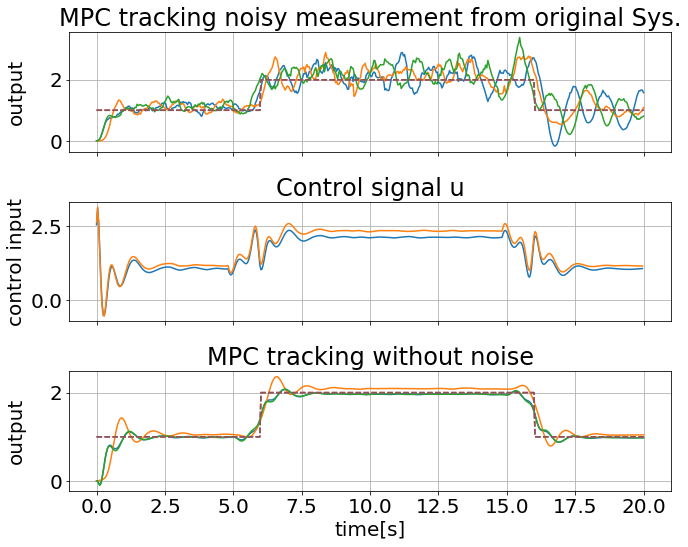

In [30]:
## results visualization ##
res_x_T = np.concatenate(res_x,axis=1)
res_u = np.array(res_u)
res_u = res_u.reshape(time.shape[0]-1,nu)
res_y = np.array(y_res)

y0 = np.zeros((ny,1))
res_y_withoutnoise = [y0]
for n in range(len(time)-1):
    temp = (Cb@res_x_T[:,n]).reshape(Cb.shape[0],1) + (Dr@res_u[n,:]).reshape(Cb.shape[0],1)
    res_y_withoutnoise.append(temp)
res_y_withoutnoise = np.array(res_y_withoutnoise).reshape(len(time),Cb.shape[0])


fig, ax = plt.subplots(3,1, figsize=(10,8), sharex=True)
ax[0].plot(time,res_y)
ax[0].plot(time,REFERENCE.T[:N_sim], '--')
ax[0].set_title('MPC tracking noisy measurement from original Sys.')
ax[0].set_ylabel('output')
ax[0].grid()

ax[1].set_title('Control signal u')
ax[1].plot(time[:-1],res_u)
ax[1].set_ylabel('control input')
ax[1].grid()

ax[2].plot(time,res_y_withoutnoise)
ax[2].plot(time,REFERENCE.T[:N_sim], '--')
ax[2].set_title('MPC tracking without noise')
ax[2].set_xlabel('time[s]')
ax[2].set_ylabel('output')
ax[2].grid()

fig.align_ylabels()
fig.tight_layout()

plt.savefig('constant',dpi=250)